# Искусственный интеллект
## ЛР 3 (часть 2)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import PIL

import torch
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
random_state = 0xDEAD
np.random.seed(random_state)
torch.random.manual_seed(random_state)
torch.cuda.random.manual_seed_all(random_state);

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Загрузка датасета
### Oxford pets

In [4]:
!wget https://mslearntensorflowlp.blob.core.windows.net/data/oxpets_images.tar.gz
!tar xfz oxpets_images.tar.gz
!rm oxpets_images.tar.gz

--2022-05-29 19:34:40--  https://mslearntensorflowlp.blob.core.windows.net/data/oxpets_images.tar.gz
Resolving mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)... 20.150.90.68
Connecting to mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)|20.150.90.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘oxpets_images.tar.gz’

oxpets_images.tar.g 100%[===================>] 755.23M  31.9MB/s    in 23s     

2022-05-29 19:35:03 (33.0 MB/s) - ‘oxpets_images.tar.gz’ saved [791918971/791918971]



Имеем просто папку с картинками. Запихаем каждый класс в отдельную папку, чтобы потом можно было использовать стандартные функции для считывания данных

In [5]:
images = os.listdir('images')

In [6]:
def get_class(string):
    for i, ch in enumerate(string):
        if ch.isdigit():
            return string[:i-1]

In [7]:
classes = list(set([get_class(img) for img in images if get_class(img) is not None]))
classes

['Bengal',
 'Russian_Blue',
 'great_pyrenees',
 'american_pit_bull_terrier',
 'pug',
 'chihuahua',
 'Abyssinian',
 'miniature_pinscher',
 'Sphynx',
 'boxer',
 'shiba_inu',
 'yorkshire_terrier',
 'Ragdoll',
 'Siamese',
 'Maine_Coon',
 'american_bulldog',
 'pomeranian',
 'basset_hound',
 'german_shorthaired',
 'Bombay',
 'havanese',
 'saint_bernard',
 'scottish_terrier',
 'english_cocker_spaniel',
 'english_setter',
 'leonberger',
 'staffordshire_bull_terrier',
 'British_Shorthair',
 'keeshond',
 'Persian',
 'Birman',
 'japanese_chin',
 'beagle',
 'wheaten_terrier',
 'samoyed',
 'newfoundland',
 'Egyptian_Mau']

Сразу поделим датасет на трейн и вал. Под валидацию оставим 20% картинок

In [8]:
os.makedirs('./dataset')
os.makedirs('./dataset/train')
os.makedirs('./dataset/val')
val_size = 0.2

for cl in classes:
    os.makedirs(os.path.join('dataset/train', cl))
    os.makedirs(os.path.join('dataset/val', cl))

In [9]:
for i, image in enumerate(images):
    cur_class = get_class(image)
    if cur_class is None:
        continue
    if np.random.random(1) < 1 - val_size:
        shutil.copy(os.path.join('images', image), os.path.join('dataset/train', cur_class))
    else:
        shutil.copy(os.path.join('images', image), os.path.join('dataset/val', cur_class))

Сразу преобразуем картинки к тензору и нормируем их

In [10]:
transform = transforms.Compose([
                                transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

train_dataset = datasets.ImageFolder('/content/dataset/train', transform=transform)
val_dataset = datasets.ImageFolder('/content/dataset/val', transform=transform)

In [11]:
len(train_dataset), len(val_dataset)

(5881, 1509)

Сделаем даталоадеры

In [12]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

## Функции для обучения модели

In [13]:
def train_model(model, train_loader, test_loader, epochs_num, optimizer, criterion, device):
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []

    for epoch in range(epochs_num):
        cur_train_acc = 0
        cur_test_acc = 0

        cur_train_loss = 0
        cur_test_loss = 0

        # training
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            cur_train_loss += loss.item()

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # count metrics
            cur_train_acc += (y_batch.squeeze() == torch.argmax(y_pred, axis=1)).cpu().numpy().sum()
            
        # testing
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                y_pred = model(X_batch)
                cur_test_acc += (y_batch.squeeze() == torch.argmax(y_pred, axis=1)).cpu().numpy().sum()

                loss = criterion(y_pred, y_batch)
                cur_test_loss += loss.cpu().item()

        
        train_acc_history.append(cur_train_acc / (len(train_loader) * batch_size))
        test_acc_history.append(cur_test_acc / (len(test_loader) * batch_size))
        train_loss_history.append(cur_train_loss / (len(train_loader) * batch_size))
        test_loss_history.append(cur_test_loss / (len(test_loader) * batch_size))
    
    return train_loss_history, test_loss_history, train_acc_history, test_acc_history

In [14]:
def plot_loss_history(train_loss_history, test_loss_history):
    plt.figure(figsize=(10, 8))
    plt.title("Loss")
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, linewidth=2, label='train loss')
    plt.plot(range(1, len(test_loss_history) + 1), test_loss_history, linewidth=2, label='test loss')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [15]:
def plot_acc_history(train_acc_history, test_acc_history):
    plt.figure(figsize=(10, 8))
    plt.title("Accuracy")
    plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, linewidth=2, label='train accuracy')
    plt.plot(range(1, len(test_acc_history) + 1), test_acc_history, linewidth=2, label='test accuracy')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

Построение матрицы неточностей:

In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader):
    preds = None
    reals = None
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            if preds is None:
                preds = torch.argmax(y_pred, axis=1).cpu().numpy()
                reals = y_batch.cpu().numpy()
            else:
                preds = np.hstack([preds, torch.argmax(y_pred, axis=1).cpu().numpy()])
                reals = np.hstack([reals, y_batch.cpu().numpy()])

    confustion_matrix = confusion_matrix(reals, preds)
    df_cm = pd.DataFrame(confustion_matrix, index = [i for i in classes], columns = [i for i in classes])
    plt.figure(figsize = (15, 15))
    sns.heatmap(df_cm, annot=True, cmap='Blues')
    plt.show()

## Обучение моделей

Попробуем дообучить VGG16

In [18]:
vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [19]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Заменим последний слой классификатора, чтобы он подходил по размеру под наш датасет

In [20]:
vgg.classifier[6] = nn.Linear(4096, len(classes))

Много эпох ставить нет смысла. Я пробовал обучать модель на 10 эпохах, но результат все время был примерно одинаковым. Поэтому доучим всего 3 эпохи. Так как эта сеть уже обучена на имеджнете, то распознавать фичи на картинках она уже умеет

In [21]:
vgg = vgg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=1e-4)

epochs = 2

In [22]:
vgg_stats = train_model(vgg, train_loader, val_loader, epochs, optimizer, criterion, device)

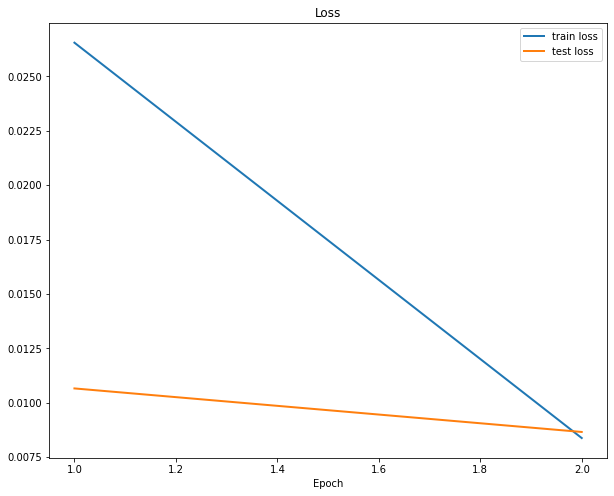

In [23]:
plot_loss_history(vgg_stats[0], vgg_stats[1])

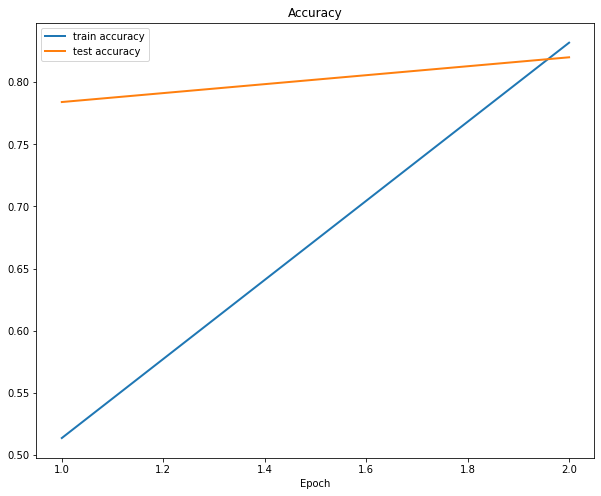

In [24]:
plot_acc_history(vgg_stats[2], vgg_stats[3])

In [25]:
print('Final accuracy =', vgg_stats[3][-1])

Final accuracy = 0.8199728260869565


Теперь попробуем дообучить ResNet18

In [26]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [27]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
resnet.fc = nn.Linear(512, len(classes))

In [29]:
resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

epochs = 2

In [30]:
resnet_stats = train_model(resnet, train_loader, val_loader, epochs, optimizer, criterion, device)

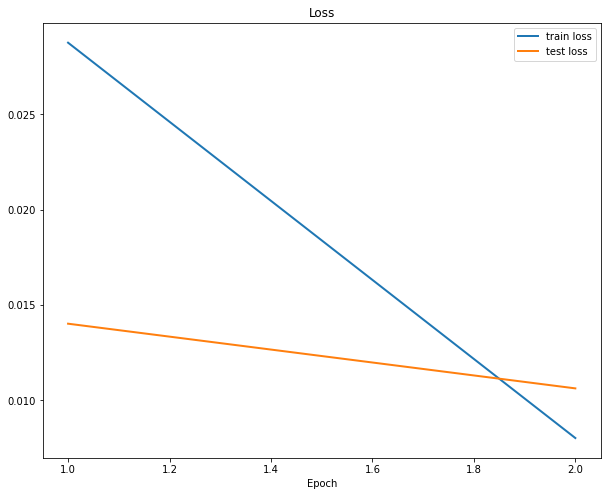

In [31]:
plot_loss_history(resnet_stats[0], resnet_stats[1])

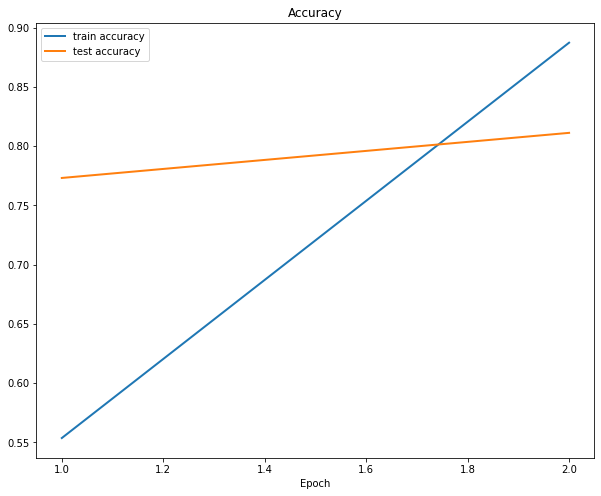

In [32]:
plot_acc_history(resnet_stats[2], resnet_stats[3])

In [33]:
print('Final accuracy =', resnet_stats[3][-1])

Final accuracy = 0.811141304347826


Результаты у сеток получились примерно одинаковые: accuracy = 0.81. Рассмотрим реснет более детально: построим для него матрицу неточностей и посчитаем топ к эккюраси:

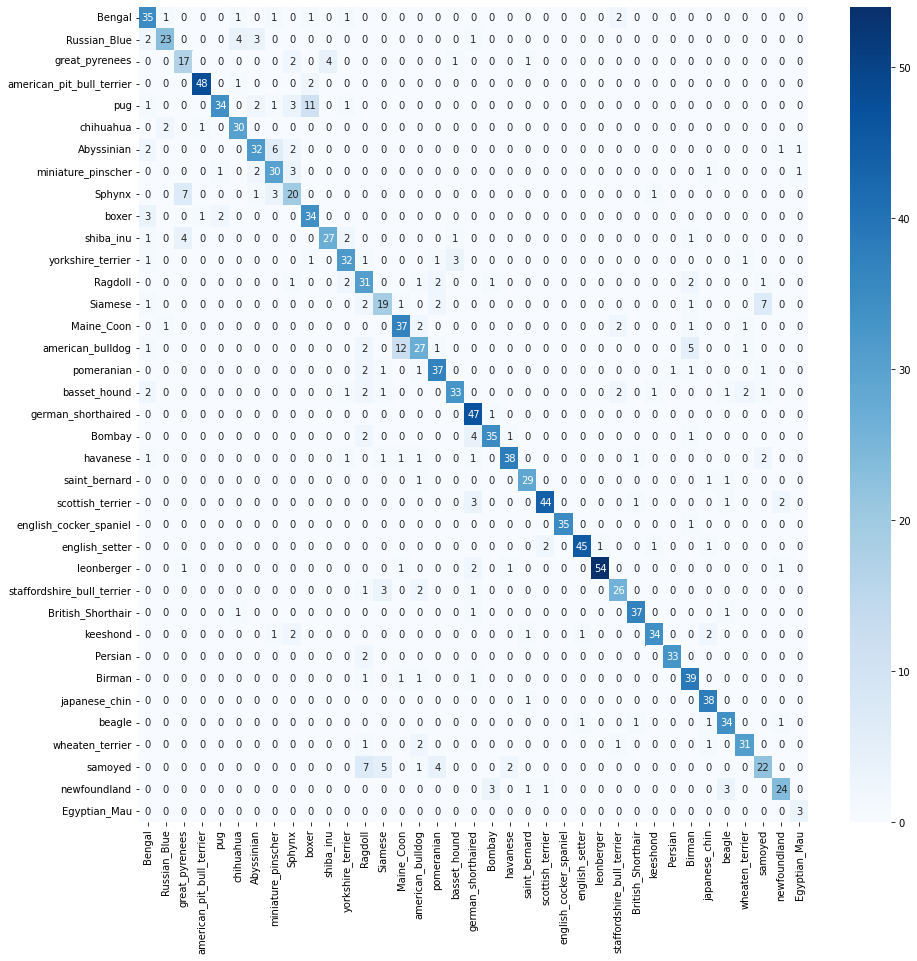

In [34]:
plot_confusion_matrix(resnet, val_loader)

Модель хорошо справляется с задачей: почти все элементы датасета находятся на диагонали матрицы неточностей.

Посчитаем топ 3 и топ 5 эккюраси.

In [43]:
from sklearn.metrics import top_k_accuracy_score

def get_top_k_accuracy(model, val, k):
    preds = None
    reals = None
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            if preds is None:
                preds = y_pred.cpu().numpy()
                reals = y_batch.cpu().numpy()
            else:
                preds = np.vstack([preds, y_pred.cpu().numpy()])
                reals = np.concatenate([reals, y_batch.cpu().numpy()])
    return top_k_accuracy_score(reals, preds, k=k)

In [44]:
get_top_k_accuracy(resnet, val_loader, 3)

0.954483695652174

In [45]:
get_top_k_accuracy(resnet, val_loader, 5)

0.9782608695652174

Видим, что правильный ответ находится в топ 3 вариантах модели в 95% случаев, а в топ 5 - в 98%.

Точность бинарной классификации - кошки vs собаки:

К сожалению, из датасета нельзя быстро понять, какая из пород относится к собакам, а какая к кошкам. А на ручную разметку времени, к сожалению нет :(

Но мы можем прикинуть точность по построенной конфьюжен матрице. Я посмотрел на ячейки с большими числами, которые не лежат на диагонали. Там я увидел несколько случаев, когда модель просто путает породы собак (или породы кошек). Но иногда она путает собак и кошек в принципе (например, 12 раз она перепутала бульдога с мейн куном). Но в целом таких случаев не так много - не больше 50. Значит, точность классификации кошек и собак примерно равна 96% (или даже выше)


In [47]:
1 - (50 / len(val_dataset))

0.9668654738237243